In [2]:
import numpy as np
import matplotlib.pyplot as plt
from dmipy.core.acquisition_scheme import acquisition_scheme_from_schemefile
from scipy import ndimage
import nibabel as nib

/home/mmiv/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [76]:
data = nib.load("/home/mmiv/Master-project/data/GS55_all.nii.gz").get_fdata()
img_mask = nib.load("/home/mmiv/Master-project/data/GS55_all_mask.nii").get_fdata()
pred_radi = np.load("results/radii_9180_160.npy").reshape([256,256,16])
pred_f_sphere = np.load("results/f_sphere_9180_160.npy").reshape([256,256,16])
pred_f_ball = np.load("results/f_ball_9180_160.npy").reshape([256,256,16])
pred_f_stick = np.load("results/f_stick_9180_160.npy").reshape([256,256,16])


ValueError: cannot reshape array of size 396450 into shape (256,256,16)

In [72]:
mask = img_mask == 0

pred_radi[mask] = 0
pred_f_sphere[mask] = 0
pred_f_ball[mask] = 0
pred_f_stick[mask] = 0



## NIB to numpy

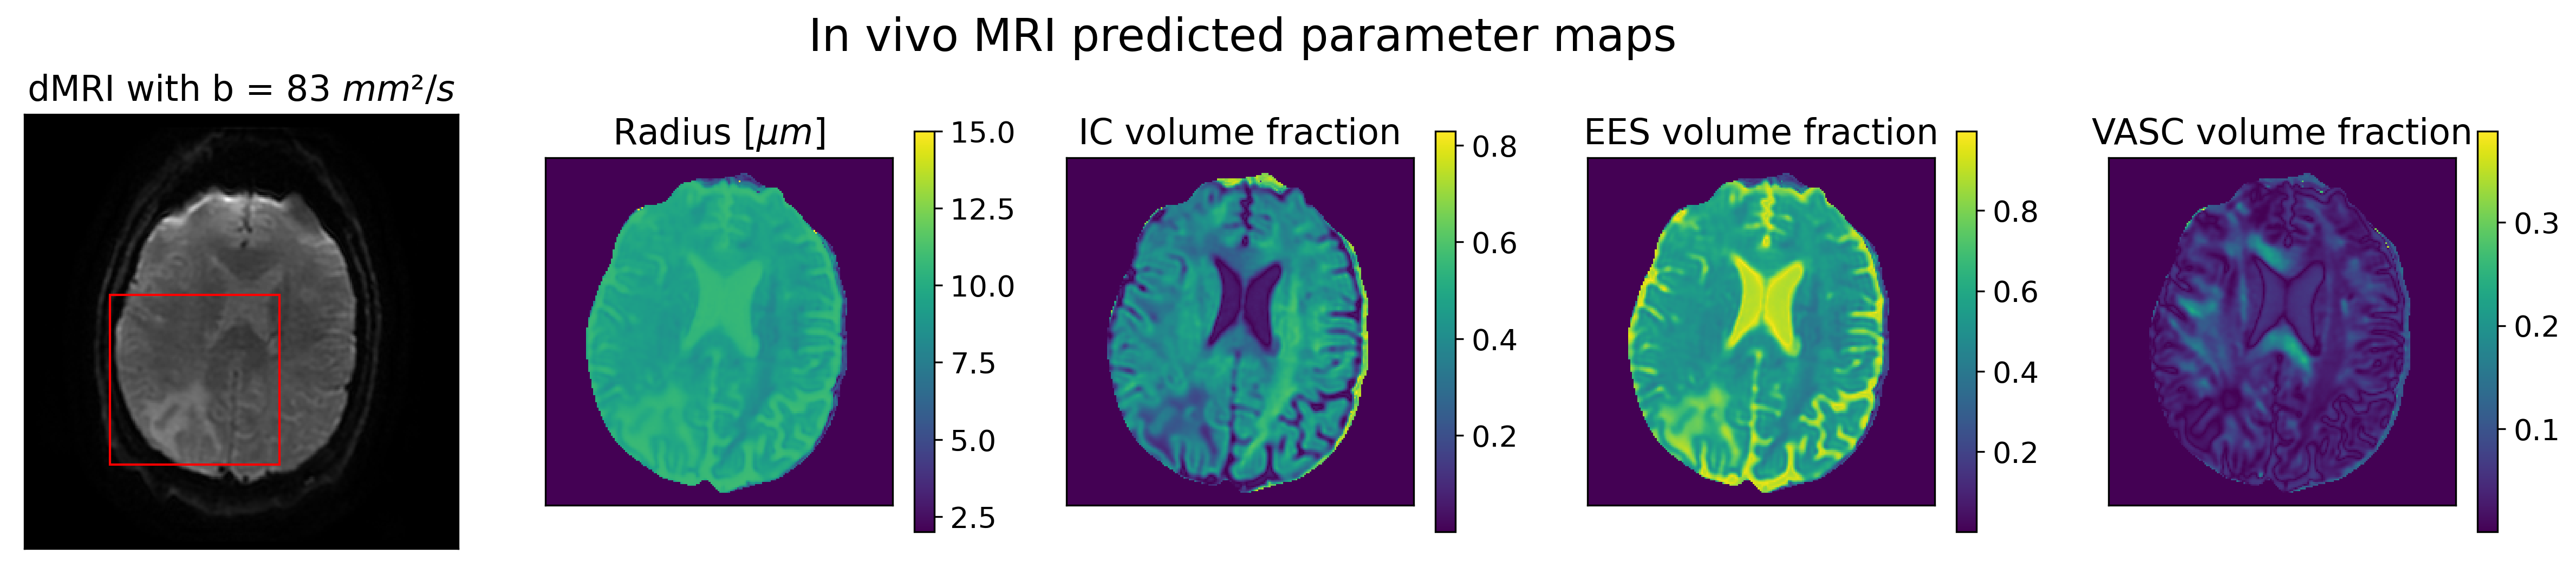

In [75]:
import matplotlib.patches as patches

image = ndimage.rotate(data[:,:,14,1], 90)
images = [image,pred_radi[30:226,30:226,14],pred_f_sphere[30:226,30:226,14],pred_f_ball[30:226,30:226,14],pred_f_stick[30:226,30:226,14]]
names = ["dMRI with b = 83 $mm²/s$","Radius $[\mu m]$",'IC volume fraction','EES volume fraction','VASC volume fraction']  

plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 13

fig = plt.figure(figsize=(20,4))

ax1 = plt.subplot2grid(shape=(1, 5), loc=(0, 0))
ax2 = plt.subplot2grid(shape=(1, 5), loc=(0, 1))
ax3 = plt.subplot2grid(shape=(1, 5), loc=(0, 2))
ax4 = plt.subplot2grid(shape=(1, 5), loc=(0, 3))
ax5 = plt.subplot2grid((1, 5), (0, 4))

axes = [ax1,ax2,ax3,ax4,ax5]

for i in range(len(axes)):

    if i == 0:
        axes[i].imshow(images[i],cmap='gray')
        rect = patches.Rectangle((50,256-50-100),100,100,linewidth=1,edgecolor='r',facecolor='none')
        axes[i].add_patch(rect)
        
    else:
        image = axes[i].imshow(ndimage.rotate(images[i], 90),cmap='viridis')
        mappable = image
        
        if i == 1:
            mappable.set_clim(2,15)
        else:
            mappable.set_clim(np.min(images[i][np.nonzero(images[i])]), images[i].max())
        fig.colorbar(mappable, ax=axes[i], shrink=0.8)


    axes[i].set_title(names[i])

    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)

fig.suptitle('In vivo MRI predicted parameter maps',fontsize=20)
plt.show()



In [5]:

def get_scheme_values(path_to_acqscheme, no_zero_values=True):
    
    scheme = acquisition_scheme_from_schemefile(path_to_acqscheme)

    b_values = scheme.bvalues
    gradient_strength = scheme.gradient_strengths
    gradient_directions = scheme.gradient_directions
    delta = scheme.delta
    Delta = scheme.Delta

    if no_zero_values:
        zero_idx = np.where(gradient_strength==0)
        b_values = torch.FloatTensor(np.delete(b_values,zero_idx))
        gradient_strength = torch.FloatTensor(np.delete(gradient_strength,zero_idx))
        gradient_directions = torch.FloatTensor(np.delete(gradient_directions,zero_idx,0))
        delta = torch.FloatTensor(np.delete(delta,zero_idx))
        Delta = torch.FloatTensor(np.delete(Delta,zero_idx))
    
    else:
        b_values = torch.FloatTensor(b_values)
        gradient_strength = torch.FloatTensor(gradient_strength)
        gradient_directions = torch.FloatTensor(gradient_directions)
        delta = torch.FloatTensor(delta)
        Delta = torch.FloatTensor(Delta)
    return b_values, gradient_strength, gradient_directions, delta, Delta

In [33]:
path_to_acqscheme = "/Users/theavage/Documents/Master/Master-project/data/3466.scheme"

b_values, g, gradient_directions, delta, Delta = get_scheme_values(path_to_acqscheme, no_zero_values=True)
i = 1
sphere_attenuation(g[i], delta[i], Delta[i], 1)


tensor(1.0000)

In [24]:
print(sphere_attenuation(g, delta, Delta, 30))

tensor([9.7147e-01, 9.7147e-01, 9.7147e-01,  ..., 1.6586e-07, 1.6586e-07,
        1.6586e-07])


In [62]:
import nibabel as nib
datapath = "/home/mmiv/Master-project/data/P55_norm.nii"
maskpath = "/home/mmiv/Master-project/data/GS55_all_mask.nii"
data = nib.load(datapath).get_fdata()
mask = nib.load(maskpath).get_fdata()


In [64]:
mask.shape

(256, 256, 16)

In [65]:
new_data = np.empty(data.shape)
for i in range(data.shape[-1]):
    new_data[...,i][mask!=0] = data[...,i][mask!=0].flatten()


In [66]:
data = np.nan_to_num(new_data,posinf=1,neginf=0)

In [64]:
img_mask = nib.load("/home/mmiv/Master-project/data/GS55_all_mask.nii").get_fdata()
img_mask = np.tile(img_mask[...,np.newaxis],(1,1,1,160))
img_mask = np.reshape(img_mask,[img_mask.shape[0]*img_mask.shape[1]*img_mask.shape[2],img_mask.shape[3]])

In [55]:
data = np.reshape(data,[data.shape[0]*data.shape[1]*data.shape[2],data.shape[3]])

In [70]:
data.shape

(1048576, 160)

In [69]:
(data[img_mask==1])

54494880

In [81]:
X,radii, f_sphere, f_ball, f_stick = np.zeros([5,50,1])

In [82]:
X.shape

(50, 1)